In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pyspark.sql.functions import col, array_contains, when
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("logistic_regression").getOrCreate()

# Let's assume 'df' is your original DataFrame and 'isMoA' is your label column
biodata_all = spark.read.parquet("data/analysis/biodata_all_v2", header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/22 14:56:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Define a new column 'isGE_plus' based on the contents of 'sources'
biodata_GE_plus = biodata_all.withColumn(
    'isGE_plus',
    F.when((F.col('sources').isNull()) | (F.size(F.col('sources')) == 0), F.lit(False))
    .otherwise(F.lit(True))
)
biodata_GE_plus.show()

23/11/22 14:57:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+---

In [4]:
# Define the undesired lists as column expressions for comparison
undesired_chembl = F.array([F.lit('chembl')])
undesired_chemicalProbes = F.array([F.lit('chemicalProbes')])
undesired_both = F.array([F.lit('chembl'), F.lit('chemicalProbes')])
undesired_both_alt = F.array([F.lit('chemicalProbes'), F.lit('chembl')])

# Assuming biodata_all is your DataFrame
# Add the 'isGE' column
biodata_with_GE = biodata_GE_plus.withColumn(
    'isGE',
    ~(
        (F.col('sources').isNull()) |
        (F.size(F.col('sources')) == 0) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chembl)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_chemicalProbes)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both)) |
        (F.array_sort(F.col('sources')) == F.array_sort(undesired_both_alt))
    )
)
biodata_with_GE.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+-----+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus| isGE|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+---------

In [5]:
# Probes column processing
biodata_GE_prob = biodata_with_GE.withColumn(
    'isHighQualityProbe_true',
    when(col('isHighQualityProbe').isNull(), False).otherwise(col('isHighQualityProbe'))
)

biodata_GE_prob.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+-----+-----------------------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus| isGE|isHighQualityProbe_true|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+----

In [25]:
# Kinase = true or false
biodata_GE_kinase = biodata_GE_prob.withColumn(
    'Kinase', when(biodata_GE_prob['proteinClass'] == 'Kinase', True).otherwise(False)
)
biodata_GE_kinase.show()

+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+----------------+------------+--------------+--------------+-----------------+-------------+---------------+-----+------------+---------+--------------------+------------------+-------------------+------------+--------+---------+-----+-----------------------+------+
|accession|   chembl_id|molregno|assay_chembl_id|src_id|src_short_name|             journal|  pubmed_id|                 doi|   tid|           pref_name|target_chembl_id|    organism|standard_value|standard_units|standard_relation|pchembl_value|       targetID|isMoA|      drugId|uniprotId|             sources|isHighQualityProbe|isTherapeuticTarget|proteinClass|isActive|isGE_plus| isGE|isHighQualityProbe_true|Kinase|
+---------+------------+--------+---------------+------+--------------+--------------------+-----------+--------------------+------+--------------------+-------

In [26]:
pandas_df = biodata_GE_kinase.toPandas()

In [27]:
# Check the data types
print(pandas_df.dtypes)

# Convert booleans to integers
pandas_df['isMoA'] = pandas_df['isMoA'].astype(int)
pandas_df['isGE'] = pandas_df['isGE'].astype(int)
pandas_df['isGE_plus'] = pandas_df['isGE_plus'].astype(int)
pandas_df['Kinase'] = pandas_df['Kinase'].astype(int)
pandas_df['isHighQualityProbe_true'] = pandas_df['isHighQualityProbe_true'].astype(int)

accession                   object
chembl_id                   object
molregno                     int32
assay_chembl_id             object
src_id                       int32
src_short_name              object
journal                     object
pubmed_id                  float64
doi                         object
tid                          int32
pref_name                   object
target_chembl_id            object
organism                    object
standard_value             float64
standard_units              object
standard_relation           object
pchembl_value              float64
targetID                    object
isMoA                         bool
drugId                      object
uniprotId                   object
sources                     object
isHighQualityProbe          object
isTherapeuticTarget         object
proteinClass                object
isActive                      bool
isGE_plus                     bool
isGE                          bool
isHighQualityProbe_t

In [28]:
# Splitting the dataset into train and test sets
train, test = train_test_split(pandas_df, test_size=0.2, random_state=42)  # 80% training and 20% testing

In [29]:
# Separate the independent variables and the dependent variable in the training set
X_train_a = train[['pchembl_value']] # Model based on activity
X_train_g = train[['isGE']] # Model based on GE
X_train_ag = train[['pchembl_value', 'isGE']] # Model based on activity and GE
X_train_agk = train[['pchembl_value', 'isGE', 'Kinase']]
y_train_m = train['isMoA']
y_train_p = train['isHighQualityProbe_true']

In [30]:
# Add a constant to the independent variable set to represent the intercept
X_train_a = sm.add_constant(X_train_a)
X_train_g = sm.add_constant(X_train_g)
X_train_ag = sm.add_constant(X_train_ag)
X_train_agk = sm.add_constant(X_train_agk)

In [31]:
# # Building the logistic regression model
# logit_model_a_m = sm.Logit(y_train_m, X_train_a)
# logit_model_g_m = sm.Logit(y_train_m, X_train_g)
# logit_model_ag_m = sm.Logit(y_train_m, X_train_ag)
logit_model_agk_m = sm.Logit(y_train_m, X_train_agk)

# # Building the logistic regression model
# logit_model_a_p = sm.Logit(y_train_p, X_train_a)
# logit_model_g_p = sm.Logit(y_train_p, X_train_g)
# logit_model_ag_p = sm.Logit(y_train_p, X_train_ag)

In [32]:
# # Fitting the model
# result_a_m = logit_model_a_m.fit()
# result_g_m = logit_model_g_m.fit()
# result_ag_m = logit_model_ag_m.fit()
result_agk_m = logit_model_agk_m.fit()

# result_a_p = logit_model_a_p.fit()
# result_g_p = logit_model_g_p.fit()
# result_ag_p = logit_model_ag_p.fit()

Optimization terminated successfully.
         Current function value: 0.247362
         Iterations 8


In [33]:
# Display the results
print(result_agk_m.summary())

                           Logit Regression Results                           
Dep. Variable:                  isMoA   No. Observations:                23766
Model:                          Logit   Df Residuals:                    23762
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Nov 2023   Pseudo R-squ.:                  0.2667
Time:                        16:36:27   Log-Likelihood:                -5878.8
converged:                       True   LL-Null:                       -8017.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.6050      0.147    -58.552      0.000      -8.893      -8.317
pchembl_value     0.8254      0.018     46.361      0.000       0.790       0.860
isGE              1.8527      0.051     

In [52]:
import numpy as np

# Coefficients for pchembl_value
coef_pchembl_value = 0.8264
ci_lower_pchembl_value = 0.791
ci_upper_pchembl_value = 0.861

# Coefficients for isGE
coef_isGE = 1.7084
ci_lower_isGE = 1.613
ci_upper_isGE = 1.804

# Calculate Odds Ratios and their 95% Confidence Intervals
or_pchembl_value = np.exp(coef_pchembl_value)
or_ci_lower_pchembl_value = np.exp(ci_lower_pchembl_value)
or_ci_upper_pchembl_value = np.exp(ci_upper_pchembl_value)

or_isGE = np.exp(coef_isGE)
or_ci_lower_isGE = np.exp(ci_lower_isGE)
or_ci_upper_isGE = np.exp(ci_upper_isGE)

print("Odds Ratio for pchembl_value: {:.4f}".format(or_pchembl_value))
print("95% CI for pchembl_value: {:.4f}, {:.4f}".format(or_ci_lower_pchembl_value, or_ci_upper_pchembl_value))

print("Odds Ratio for isGE: {:.4f}".format(or_isGE))
print("95% CI for isGE: {:.4f}, {:.4f}".format(or_ci_lower_isGE, or_ci_upper_isGE))


Odds Ratio for pchembl_value: 2.2851
95% CI for pchembl_value: 2.2056, 2.3655
Odds Ratio for isGE: 5.5201
95% CI for isGE: 5.0178, 6.0739


In [35]:
# To get the Odds Ratio for 'isGE'
params = result_agk_m.params
conf = result_agk_m.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
# Exponentiating the coefficients to get the odds ratios
# print("Odds Ratio for isGE:")
print(np.exp(conf.loc['Kinase']))

2.5%     0.356475
97.5%    0.437454
OR       0.394894
Name: Kinase, dtype: float64


23/11/22 17:18:22 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 416457 ms exceeds timeout 120000 ms
23/11/22 17:18:22 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/22 17:18:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

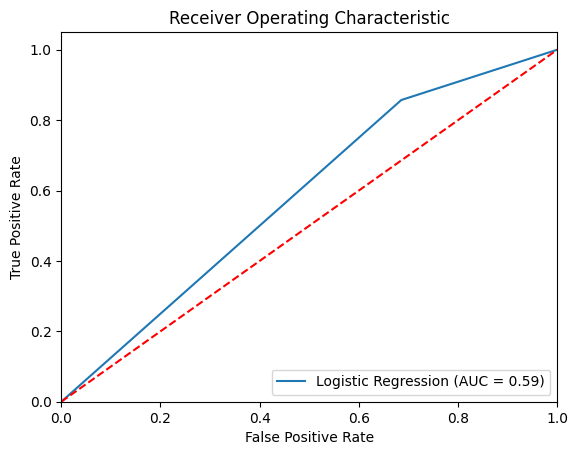

23/11/09 18:34:33 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 173310 ms exceeds timeout 120000 ms
23/11/09 18:34:33 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/09 18:34:42 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [66]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Separate the independent variables and the dependent variable in the test set
X_test = test[['isGE']]
y_test = test['isHighQualityProbe_true']

# Add a constant to the independent variable set to represent the intercept
X_test = sm.add_constant(X_test)

# Making predictions on the test set (we need probability predictions for ROC)
y_pred_prob = result_g_p.predict(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')  # Dashed diagonal line representing a no-skill classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Run model for isGE_plus

In [59]:
# Separate the independent variables and the dependent variable in the training set
X_train = train[['pchembl_value', 'isGE_plus']]
y_train = train['isMoA']

In [60]:
# Add a constant to the independent variable set to represent the intercept
X_train = sm.add_constant(X_train)

In [61]:
# Building the logistic regression model
logit_model = sm.Logit(y_train, X_train)

In [62]:
# Fitting the model
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.248850
         Iterations 13


In [63]:
# Display the results
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                  isMoA   No. Observations:                23766
Model:                          Logit   Df Residuals:                    23763
Method:                           MLE   Df Model:                            2
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2623
Time:                        20:41:03   Log-Likelihood:                -5914.2
converged:                       True   LL-Null:                       -8017.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -12.2890      0.717    -17.134      0.000     -13.695     -10.883
pchembl_value     0.5873      0.017     34.092      0.000       0.554       0.621
isGE_plus         6.3684      0.708     

In [64]:
# To get the Odds Ratio for 'isGE_plus'
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
# Exponentiating the coefficients to get the odds ratios
print("Odds Ratio for isGE_plus:")
print(np.exp(conf.loc['isGE_plus']))

Odds Ratio for isGE_plus:
2.5%      145.635200
97.5%    2334.664476
OR        583.103187
Name: isGE_plus, dtype: float64


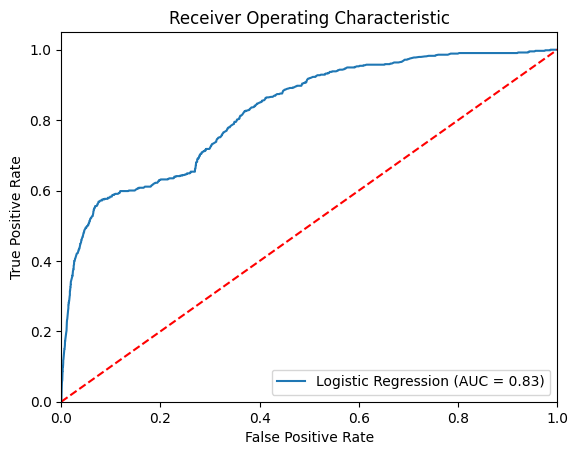

23/11/06 23:09:50 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 661461 ms exceeds timeout 120000 ms
23/11/06 23:09:50 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/06 23:09:53 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [65]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Separate the independent variables and the dependent variable in the test set
X_test = test[['pchembl_value', 'isGE']]
y_test = test['isMoA']

# Add a constant to the independent variable set to represent the intercept
X_test = sm.add_constant(X_test)

# Making predictions on the test set (we need probability predictions for ROC)
y_pred_prob = result.predict(X_test)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')  # Dashed diagonal line representing a no-skill classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Log regression: MoA prediction by pchembl_value, isGE and proteinClass

In [10]:
unique_protein_classes = pandas_df['proteinClass'].unique()
# Filter out None values
filtered_classes = [x for x in unique_protein_classes if x is not None]
# Sort and print
print(sorted(filtered_classes))


['Enzyme', 'Epigenetic', 'GPCR', 'IC', 'Kinase', 'NR', 'None', 'TF', 'TF; Epigenetic', 'Transporter', 'oGPCR']


In [ ]:
#